<center>
    <img src="https://static.wixstatic.com/media/370a7e_5b2071d61a6e4dd88466b627c307fe37~mv2.png/v1/fill/w_448,h_152,al_c,usm_0.66_1.00_0.01/370a7e_5b2071d61a6e4dd88466b627c307fe37~mv2.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1>TUGAS MENTORING CLUSTERING </h1>

<h3>Adhitya Wisena <strong> , 28 Agustus 2021</strong></h3>

<h2>Persoalan Masalah</h2>
<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ul>
A simple yet powerful marketing technique is an analysis utilizing _recency_ (how recent was the customer's last purchase), _frequency_ (how often did the customer make a purchase in a given period) and _monetary_ (how much money did the customer spend in a given period) data to identify the best customers and perform targeted marketing campaigns. 

As data scientist you are asked to segment the customers using transaction data and profile them based-on their characteristics (recency, frequency, monetary). After you find the segments, name them using understandable words so marketing team can easily create campaign strategies.

**Data:**
`../data/transactions.csv`

**Hints:** 
For each customer id, generate time difference between their last transaction and today. You should also calculate number of transaction and total amount of spending. You are allowed to use SQL.

**Output:**
Push the *executed* notebook into your github repo and submit the URL to ketua kelas no later than August 21, 2021. Note that notebook must contain explanatory analysis and clustering as well as story about your findings.
    </ul>
</div>

<hr>

# Load libraries

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go
import plotly.express as px

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

from scipy.cluster.hierarchy import dendrogram, linkage
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import warnings
import os
warnings.filterwarnings("ignore")

py.offline.init_notebook_mode(connected = True)

# Data Exploration

In [4]:
df = pd.read_csv('data/transactions.csv')
df.head()

,customer_id,trans_date,trans_amount
0,CS5295,11-Feb-18,35
1,CS4768,15-Mar-20,39
2,CS2122,26-Feb-18,52
3,CS1217,16-Nov-16,99
4,CS1850,20-Nov-18,78


In [5]:
df.shape

(125000, 3)

In [6]:
df.describe()

,trans_amount
count,125000.000000
mean,64.991912
std,22.860006
min,10.000000
25%,47.000000
50%,65.000000
75%,83.000000
max,105.000000


In [7]:
df.dtypes

customer_id     object
trans_date      object
trans_amount     int64
dtype: object

# Data Preprocessing

### Mengecek missing value

In [8]:
df.isnull().mean().sort_values(ascending=False)

customer_id     0.0
trans_date      0.0
trans_amount    0.0
dtype: float64

### Mengecek kolom tanggal sudah sesuai format atau tidak

In [9]:
df['trans_date_correction'] = pd.to_datetime(df['trans_date'],errors='coerce')

In [10]:
df

,customer_id,trans_date,trans_amount,trans_date_correction
0,CS5295,11-Feb-18,35,2018-02-11
1,CS4768,15-Mar-20,39,2020-03-15
2,CS2122,26-Feb-18,52,2018-02-26
3,CS1217,16-Nov-16,99,2016-11-16
4,CS1850,20-Nov-18,78,2018-11-20
...,...,...,...,...
124995,CS8433,26-Jun-16,64,2016-06-26
124996,CS7232,19-Aug-19,38,2019-08-19
124997,CS8731,28-Nov-19,42,2019-11-28
124998,CS8133,14-Dec-18,13,2018-12-14


Memvalidasi ulang data koreksi dengan NaT

In [11]:
df.query('trans_date_correction == "NaT"')

,customer_id,trans_date,trans_amount,trans_date_correction
3460,CS3985,29-Feb-17,40,NaT
6037,CS5930,29-Feb-17,68,NaT
6732,CS4670,29-Feb-17,100,NaT
8421,CS2946,29-Feb-17,65,NaT
9102,CS5458,29-Feb-17,73,NaT
...,...,...,...,...
116145,CS8206,29-Feb-17,54,NaT
117817,CS8352,29-Feb-17,79,NaT
117855,CS7741,29-Feb-17,35,NaT
118973,CS7897,29-Feb-17,65,NaT


Ternyata ada 90 nilai yang keliru, kita cek ulang data unik nya dari kolom trans_date

In [12]:
df[df['trans_date_correction'].isnull()]['trans_date'].unique()

array(['29-Feb-17'], dtype=object)

Didapat hanya ada 1 data unik trans_date yang keliru. Kita perbaiki dengan cara menghapus row yang memiliki nilai '29-Feb-17' dari kolom 'trans_date' 

In [13]:
# Melakukan data cleansing
transactions = df.drop(df[df['trans_date']=='29-Feb-17'].index)

In [14]:
# Menghapus kolom trans_date_correction
transactions = transactions.drop(['trans_date_correction'], axis=1)

In [15]:
transactions

,customer_id,trans_date,trans_amount
0,CS5295,11-Feb-18,35
1,CS4768,15-Mar-20,39
2,CS2122,26-Feb-18,52
3,CS1217,16-Nov-16,99
4,CS1850,20-Nov-18,78
...,...,...,...
124995,CS8433,26-Jun-16,64
124996,CS7232,19-Aug-19,38
124997,CS8731,28-Nov-19,42
124998,CS8133,14-Dec-18,13


Lalu kita cek apakah ada data duplikat dan menghapus data duplikat tersebut

In [16]:
transactions.duplicated().sum()

6

In [17]:
# Menghapus data duplikat
transactions=transactions.drop_duplicates()
# Mengecek ulang hasilnya
transactions.duplicated().sum()

0

In [18]:
# Setelah data dipastikan benar, rubah tipe data trans_date menjadi datetime
transactions['trans_date']=pd.to_datetime(transactions['trans_date'])

In [19]:
#Check column data types
transactions.dtypes

customer_id             object
trans_date      datetime64[ns]
trans_amount             int64
dtype: object

In [20]:
transactions.head()

,customer_id,trans_date,trans_amount
0,CS5295,2018-02-11,35
1,CS4768,2020-03-15,39
2,CS2122,2018-02-26,52
3,CS1217,2016-11-16,99
4,CS1850,2018-11-20,78


Sesuai penjelasan pada soal, perlu dicari 3 features yaitu : 
1. recency (seberapa dekatnya pembelian terakhir customer)
2. frequency (seberapa sering customer melakukan pembelian pada periode tertentu)
3. monetary (seberapa banyak uang yang dihabiskan customer pada periode tertentu)

In [21]:
today = pd.Timestamp.today()

In [22]:
transactions['days_diff'] = (today - transactions['trans_date']).dt.days

In [23]:
# recency feature didapat dari data transaksi terakhir customer
# frequency feature didapat dari menghitung banyaknya customer
# monetary didapat dari menjumlahkan semua transaksi customer
X = transactions.groupby(['customer_id']).agg({'days_diff' : min, 'customer_id' :"count", 'trans_amount' : sum,
})

X

,days_diff,customer_id,trans_amount
customer_id,,,
CS1112,592,15,1012
CS1113,566,20,1490
CS1114,563,19,1432
CS1115,541,22,1659
CS1116,734,13,857
...,...,...,...
CS8996,628,13,582
CS8997,792,14,543
CS8998,615,13,624


In [24]:
# Mengganti nama kolom sesuai feature
X = X.rename({'days_diff': 'recency', 'customer_id': 'frequency','trans_amount': 'monetary'}, axis=1)

In [25]:
X.dtypes

recency      int64
frequency    int64
monetary     int64
dtype: object

In [26]:
X.head()

,recency,frequency,monetary
customer_id,,,
CS1112,592,15,1012
CS1113,566,20,1490
CS1114,563,19,1432
CS1115,541,22,1659
CS1116,734,13,857


In [27]:
X.shape

(6889, 3)

In [28]:
X.describe()

,recency,frequency,monetary
count,6889.000000,6889.000000,6889.000000
mean,611.349252,18.130933,1178.359123
std,85.545443,5.192154,465.606743
min,530.000000,4.000000,149.000000
25%,553.000000,14.000000,781.000000
50%,584.000000,18.000000,1227.000000
75%,642.000000,22.000000,1520.000000
max,1388.000000,39.000000,2933.000000


# Data Visualization

In [29]:
plt.style.use('seaborn')

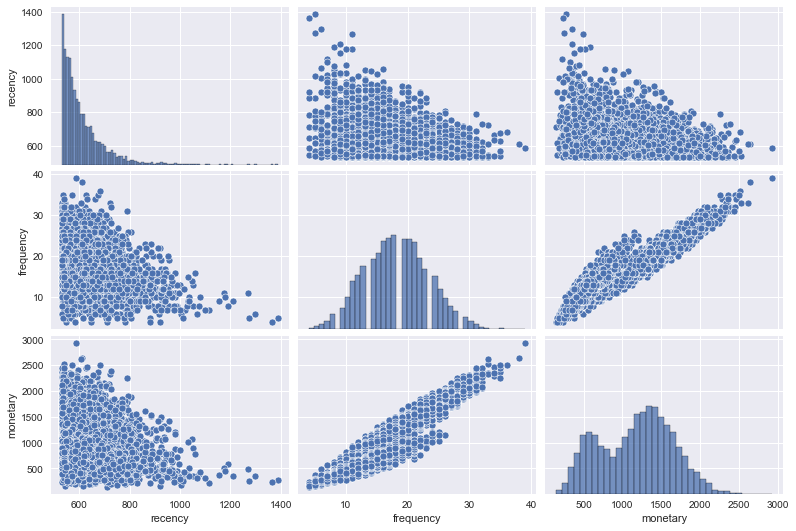

In [30]:
# Check inter varibale correlation
sns.pairplot(X, aspect=1.5)
plt.show()

Dari plot di atas dapat kita lihat bahwa terlihat ada korelasi linear antara frequency dan monetary. Sedangkan recency perlu dicari lebih jauh berhubungan dengan 2 features lainnya

### Standardized Variables

In [31]:
standardize = StandardScaler()
X_std = pd.DataFrame(standardize.fit_transform(X))
X_std.columns = X.columns
X_std.head()

,recency,frequency,monetary
0,-0.226203,-0.603056,-0.357321
1,-0.530157,0.360005,0.669371
2,-0.565229,0.167393,0.544793
3,-0.822421,0.745230,1.032364
4,1.433854,-0.988281,-0.690244


In [32]:
X_std.columns

Index(['recency', 'frequency', 'monetary'], dtype='object')

# K-Means: 2 Variables with Elbow Method and Silhouette to Determine k

In [33]:
X_is = X_std[['frequency','monetary']].values

In [34]:
def k_means_inertia_silhouette(X, k_max = 10, init = 'k-means++'):
    inertia = []
    silhouette = []
    for k in range(2, k_max):
        km =  KMeans(init = init, n_clusters = k, random_state= 123)
        km.fit(X)
        inertia.append(km.inertia_)
        silhouette.append(silhouette_score(X, km.labels_))
    
    plt.figure(1 , figsize = (15 ,6))
    plt.plot(np.arange(2 , k_max) , inertia , 'o')
    plt.plot(np.arange(2 , k_max) , inertia , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
    plt.title('The Elbow method using Inertia for each number of cluster')
    plt.show()

    plt.figure(1 , figsize = (15 ,6))
    plt.plot(np.arange(2 , k_max) , silhouette , 'o')
    plt.plot(np.arange(2 , k_max) , silhouette , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Silhouette')
    plt.title('Silhouette score for each number of cluster')
    plt.show()
    
    return inertia, silhouette

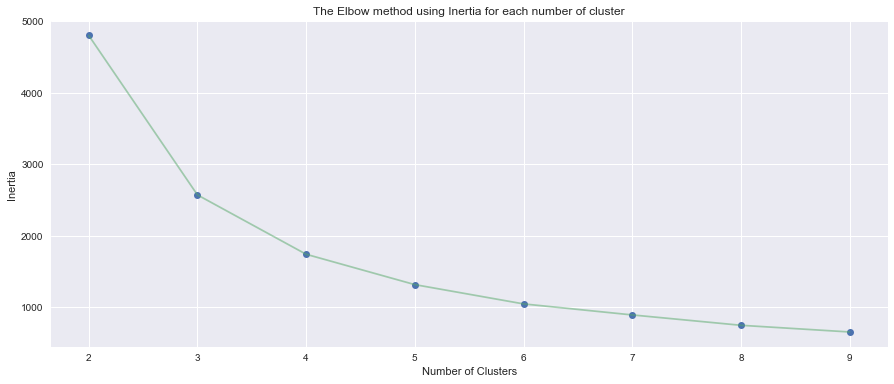

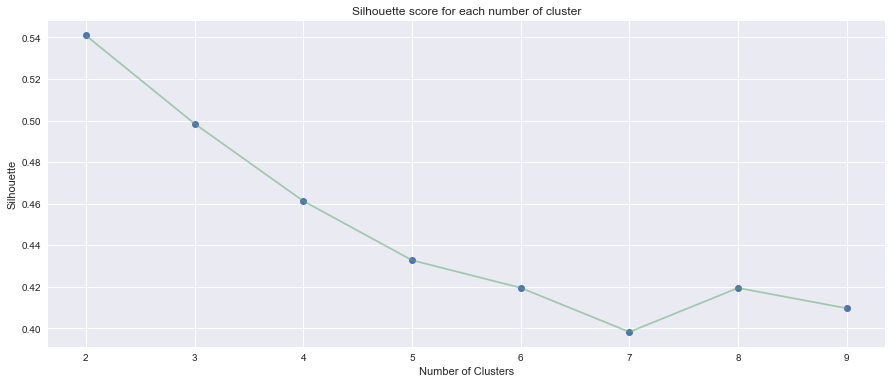

In [35]:
inertia, silhouette = k_means_inertia_silhouette(X = X_is)

Dari plot di atas, kita masih kesulitan untuk menentukan jumlah cluster yang optimal. Maka dari itu, kita coba menggunakan library yellowbrick untuk membantu menentukan banyaknya cluster.

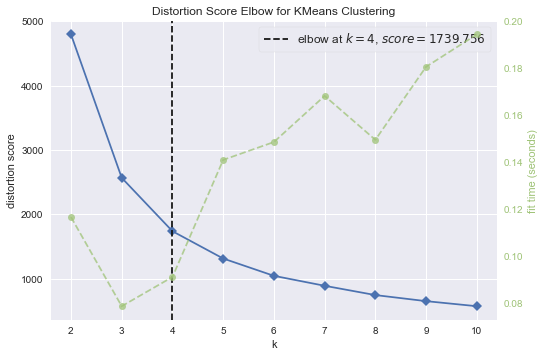

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [36]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,11))

visualizer.fit(X_is)    # Fit the data to the visualizer
visualizer.show()    # Draw/show/show the data

Dengan menggunakan KElbowVisualizer, kita bisa mendapatkan angka optimal untuk cluster yang bisa kita pilih. Data plot di atas didapat K=4 merupakan angka yg paling optimal.

In [38]:
k = 4
k_means = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_means.fit(X_is)

centroids = k_means.cluster_centers_

In [39]:
centroids

array([[-1.30154302, -1.37908193],
       [ 0.44924537,  0.53972774],
       [ 1.50782049,  1.41356274],
       [-0.36850881, -0.35473908]])

Sekarang kita plot segmennya

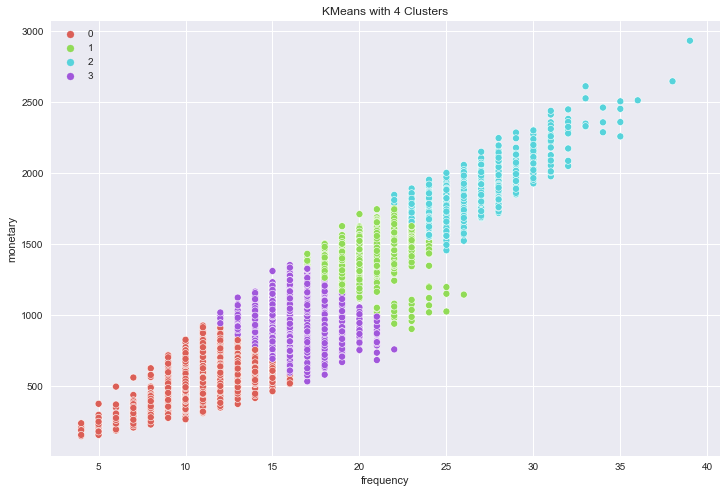

In [41]:
Segment = k_means.labels_

plt.figure(figsize=(12, 8))
sns.scatterplot(X['frequency'], X['monetary'], hue=Segment,
                palette=sns.color_palette('hls', k))
plt.title('KMeans with {} Clusters'.format(k))
plt.show()

In [42]:
centroids = X[['frequency','monetary']].groupby(Segment, as_index=False).mean()
centroids

,frequency,monetary
0,11.381759,536.765472
1,20.477293,1430.653497
2,25.966928,1836.951262
3,16.228657,1014.890165


### Kesimpulan dari K-Means 2 Variable 

1. Centroid 0 (warna merah) menunjukan tergolong **Low Priority Customer** yang kurang tertarik dengan produk yang dipasarkan sehingga frequency dan monetary nya masih tergolong rendah. Cocok untuk dipasarkan produk baru atau diskon.
2. Centroid 1 (warna ungu) menunjukan tergolong **Medium Priority Customer** dimana frequency dan monetary nya di atas kategori low priority customer. Pelanggan seperti ini cocok untuk di caring lebih intens agar naik.
3. Centroid 2 (warna hijau) menunjukan tergolong **High Priority Customer** dimana frequency dan monetary nya tinggi sehingga perlu dijaga loyalitas dari pelanggan tersebut.
4. Centroid 3 (warna biru) tergolong **Very High Priority Customer** dimana frequency dan monetary nya sangat tinggi sehingga termasuk pelanggan loyal perusahaan. Perlu diberikan reward dan penghargaan dari perusahaan.

# K-Means: 3 Variables with Elbow Method and Silhouette to Determine k

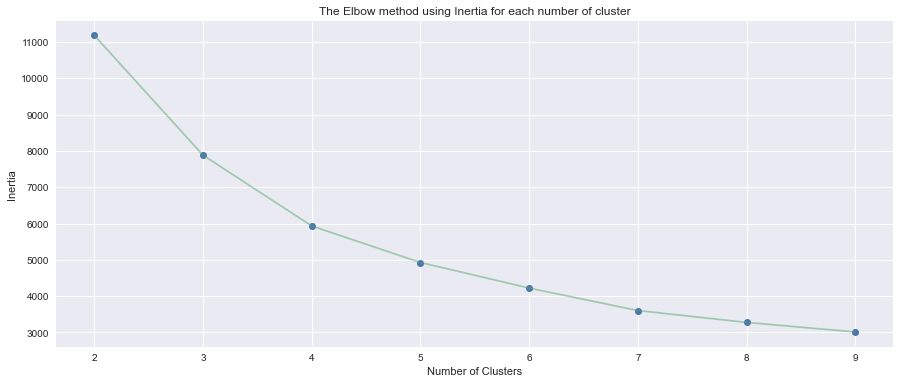

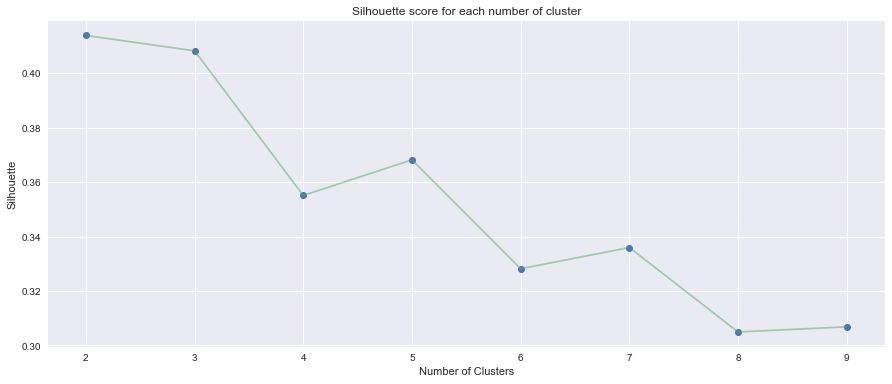

In [43]:
inertia, silhouette = k_means_inertia_silhouette(X_std, k_max = 10, init = 'k-means++')

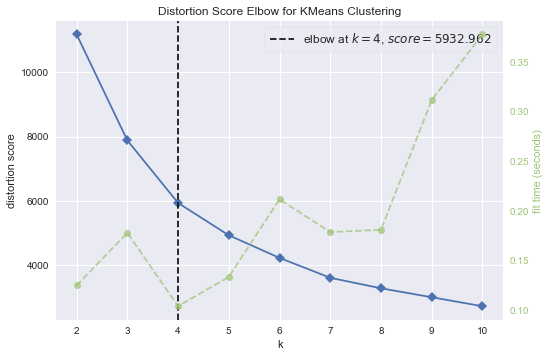

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [44]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,11))

visualizer.fit(X_std)    # Fit the data to the visualizer
visualizer.show()    # Draw/show/show the data

In [45]:
k = 4
k_means = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_means.fit(X_std)

KMeans(n_clusters=4, random_state=123)

In [46]:
Segment = k_means.labels_
X.groupby(Segment, as_index=False).mean()

,recency,frequency,monetary
0,594.984136,12.737110,643.809632
1,581.262946,24.728999,1747.445339
2,810.798752,13.188768,752.063963
3,594.346448,18.575592,1261.296539


In [48]:
X['Segment'] = list(map(str, Segment))
fig = px.scatter_3d(X, x='recency', y='frequency', z='monetary', color='Segment',
                   opacity = 0.8, height=800)
fig.show() # to show as static image: fig.show('svg') 

### Kesimpulan dari K-Means 3 Variable 

1. Centroid 2 (warna hijau) menunjukan tergolong **Loss Customer** yang kurang tertarik dengan produk yang dipasarkan sehingga transaksi terakhirnya cukup lama. Begitu pun dengan frequency dan monetary nya masih tergolong rendah. Perlu pengamanan agar tidak menjadi churn, perlu memerlukan effort yang tinggi untuk memenangkan hatinya kembali.
2. Centroid 0 (warna ungu) menunjukan tergolong **New Customer** dimana frequency dan monetary nya masih tergolong medium dengan transaksi terakhir masih baru. Pelanggan seperti ini cocok untuk diberikan promo dan diskon add-on tambahan.
3. Centroid 3 (warna biru) menunjukan tergolong **High Priority Customer** dimana frequency dan monetary nya tinggi serta transaksi terakhirnya pun baru sehingga perlu dijaga loyalitas dari pelanggan tersebut.
4. Centroid 1 (warna merah) tergolong **Very High Priority Customer** dimana frequency dan monetary nya sangat tinggi serta sering bertransaksi sehingga termasuk pelanggan loyal perusahaan. Perlu diberikan reward dan penghargaan dari perusahaan.